In [955]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy import optimize


In [956]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11]

S0_amd = 92.3
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0_amd
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [957]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [958]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

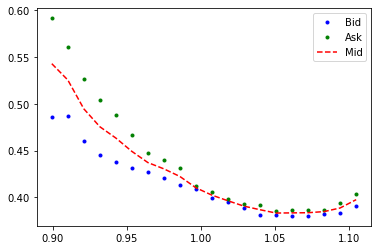

In [959]:
r = 0.01 # TODO: figure out r
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
K = np.array(C1['Strike'])
numK = len(K)
t1 = 6/252
# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

In [1068]:
# Find m0
def M(p):
    sig, beta = p[0], p[1]
    beta = 1 # TODO: take beta different from 1
    M = 0
    B = lambda s,t,k,sig: 1/2 * (s-k) * special.erf((k-s)/(np.sqrt(2*t)*sig)) + sig*np.sqrt(t/(2*math.pi))*np.exp(-(k-s)**2/(2*t*sig**2))
    for i in range(numK):
        M += (B(S0,t1,K[i],sig*S0**beta)-m[i])**2
    return M

p0 = minimize(M, np.array([75/S0,1])) 
sigma0, beta = p0.x


def m0(s1,s2): # Joint distribution of S1 and S2
    return (s1 >= 0) *  (1/(np.sqrt(2*math.pi)*(sigma0*s1))) * np.exp(-1/2*((s1-S0)/(sigma0*s1))**2)  *  (1/(np.sqrt(2*math.pi)*sigma0*s1**beta*np.sqrt(t1)) * np.exp(-1/2*((s2-s1)/(sigma0*s1**beta*np.sqrt(t1)))**2) )


def f_Kbidask(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        elif V[i]*omega[i] < delta_C_bid[i]: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f_Kbidask(V,omega,j):
    """
    j-th element of Gradient of f_kbidask with respect to V_K
    """
    
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    
    if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
        return V[j]*omega[j]
    elif V[j]*omega[j] > delta_C_ask[j]:
        return delta_C_ask[j]
    elif V[j]*omega[j] < delta_C_bid[j]: 
        return delta_C_bid[j]
        
                                                                                                        

In [1083]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*math.exp((alpha*sigma)**2/2 + alpha*s1) * (special.erf((B-alpha*sigma)/math.sqrt(2)) - special.erf((A-alpha*sigma)/math.sqrt(2)) )

#def I2(alpha,sigma,s1,K1,K2):
    #A, B = (K1-s1)/sigma, (K2-s1)/sigma
    #return sigma*math.exp(alpha*s1) *  (  2*math.exp(A*alpha*sigma-A*A/2) - math.sqrt(2*math.pi)*alpha*sigma*math.exp((alpha*sigma)**2/2)*special.erf((A-alpha*sigma)/math.sqrt(2)) + math.sqrt(2*math.pi)*alpha*sigma*np.exp((alpha*sigma)**2/2)*special.erf((B-alpha*sigma)/np.sqrt(2)) - 2*math.exp(alpha*B*sigma)-B**2/2  )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*math.exp(alpha*s1) * ( 2*(math.exp(A*alpha*sigma-A*A/2) - math.exp(B*alpha*sigma-B*B/2)) + math.sqrt(2*math.pi)*alpha*sigma*math.exp(alpha*sigma*alpha*sigma/2)*(special.erf((B-alpha*sigma)/np.sqrt(2)) - special.erf((A-alpha*sigma)/np.sqrt(2))) )

def I2_quad(alpha,sigma,s1,K1,K2):
    #return 2*math.sqrt(2*math.pi) * integrate.quad(lambda s2: math.exp(alpha*s2)*(s2-s1) * (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-1/2*((s2-s1)/sigma)**2), K1, K2)
    return integrate.quad(lambda s2: math.exp(alpha*s2)*(s2-s1) * (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-1/2*((s2-s1)/sigma)**2), K1, K2)[0]
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return math.exp(alpha*s1) *  (  2*sigma*math.exp(A*alpha*sigma-A*A/2) - math.sqrt(2*math.pi)*math.exp((alpha*sigma)**2/2)*special.erf((A-alpha*sigma)/math.sqrt(2))*(alpha*sigma**2-Q+s1) + math.sqrt(2*math.pi)*math.exp((alpha*sigma)**2/2)*special.erf((B-alpha*sigma)/math.sqrt(2))*(alpha*sigma**2-Q+s1) - 2*sigma*math.exp(alpha*B*sigma)-B**2/2  ) # K = K1

In [1099]:
def I_u(theta,V,s1,K1,K2,sigma0,beta,t1,t2): 
    assert(K1 <= K[0] and K2 >= K[-1])
    sigma = sigma0*s1**beta*np.sqrt(t2-t1)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) - theta
        gamma = sum(V[:i+1]*K[:i+1]) + theta*s1
        if (i == -1): 
            totI += np.exp(gamma) * I1(alpha,sigma,s1,K1,K[0])
        if (i != numK-1):
            totI += np.exp(gamma) * I1(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        else:
            totI += np.exp(gamma) * I1(alpha,sigma,s1,K[-1],K2)
    
    return totI


def I_h(theta,V,s1,K1,K2,sigma0,beta,t1,t2):
    assert(K1 <= K[0] and K2 >= K[-1])
    sigma = sigma0*s1**beta*np.sqrt(t2-t1)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) - theta
        print(alpha)
        print("---")
        gamma = sum(V[:i+1]*K[:i+1]) + theta*s1
        
        if (i == -1): 
            totI += np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2_quad(alpha,sigma,s1,K1,K[0])
        elif (i != numK-1):
            totI += np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2_quad(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        else:
            totI += np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I2_quad(alpha,sigma,s1,K[-1],K2)
        #print(f'totI={totI}')
        
    #print("---")
    return totI


def I_Q(h1,V,s1,Q,K1,K2,sigma0,beta,t1,t2):
    assert(K1 <= K[0] and K2 >= K[-1])
    sigma = sigma0*s1**beta*np.sqrt(t2-t1)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) - h1
        gamma = sum(V[:i+1]*K[:i+1]) + h1*s1
        
        if (i == -1): 
            totI += np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K[0],Q) * (K[0] >= Q)
        elif (i != numK-1):
            totI += np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,max(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        else:
            totI += np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,K[-1],K2,Q) * (K[-1] >= Q)
            totI += np.exp(gamma) * (1/(2*np.sqrt(2*math.pi))) * I3(alpha,sigma,s1,Q,K2,Q) * (K[-1] < Q)
        #print(f'totI = {totI}')

    return totI
    


    

In [1100]:
a, b, n = S0-20, S0+20, 11 # Take odd n, such that X1[(n-1)/2] = S0
K1, K2 = a, b
X1 = np.linspace(a,b,n) # Discrete grid
P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 
P1_disc = lambda x: P1(x)/sum(P1(X1))
#sum(P1_disc(X1)) = 1
#sum(X1*P1_disc(X1)) = 92.3 = S0
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

def G_12(V,h_S0,u_S0,omega,E_u): 
    return np.sum(u_list*P1_disc(X1)) + np.sum(f_Kbidask(V,omega)) + np.sum(V*mid) + I_u(h_S0,V,S0,K1,K2,sigma0,beta,0,t1)*np.exp(-u_S0) # Last term: S1 = S0 (corresponding u and h at middle of grid) 
    
def grad_G_12(V,h_S0,u_S0,omega,E_u):
    """
    Gradient of G_12 with respect to V_K_i
    """
    grad = np.zeros(numK)
    for i in range(numK):
        grad[i] = grad_f_Kbidask(V,omega,i) + mid[i] - I_Q(h_S0,V,S0,K[i],K1,K2,sigma0,beta,0,t1) # Q = K[i], s1 = S0
    return grad

    
    

In [1104]:
u1, h1, V = 0., 0., [0.]*numK
p0 = np.array([u1] + [h1] + V)

u_list = [0] * n
h_list = [0] * n

for i in range(n): 
    s1 = X1[i]
    # Solve for (u1,h1)
    h1 = optimize.root_scalar(f= lambda theta: I_h(theta,V,s1,a,b,sigma0,beta,0,t1)/1e7, bracket = [-1,1], method='brentq', rtol=1e-2, xtol = 1e-2).root
    u1 = -math.log(1/(I_u(h1,V,s1,a,b,sigma0,beta,0,t1)))
    
    u_list[i] = u1
    h_list[i] = h1
    

    
# Minimize G_12 as a function of V
E_u = np.sum(u_list*P1_disc(X1)) # Expecation of u1 under P1_disc
u_S0 = u_list[int((n-1)/2)] # u value corresponding to S0
h_S0 = h_list[int((n-1)/2)] # h value corresponding to S0

V_star = optimize.minimize(fun= G_12, x0=V, args=(h_S0,u_S0,omega_K,E_u), method='BFGS', jac= grad_G_12, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None).x
#jac = lambda VV: grad_G_12(u_list,h_list,VV,omega_K)
print(u_list)
print(V_star)
    
    
    
    

1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---
-1.0
---


ValueError: f(a) and f(b) must have different signs

In [ ]:
a, b, n = S0-20, S0+20, 10000
X1 = np.linspace(a,b,n) # Discrete grid
P1 = lambda x:(1/(np.sqrt(2*math.pi)*1e-1)) * np.exp(-1/2*((x-S0)/1e-1)**2) * (x >= 0) # Approximation of Dirac delta around 



In [ ]:
a, b, n = S0-20, S0+20, 11 # Take odd n, such that X1[(n-1)/2] = S0
X1 = np.array(np.linspace(a,b,n)) # Discrete grid
X1
X1[(n-1)/2]

In [ ]:
numK

In [ ]:
h_list

-4.440892098500626e-23


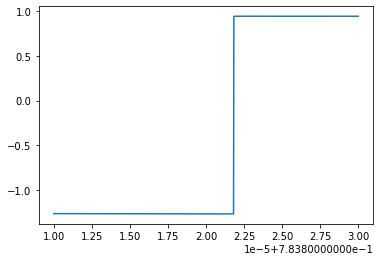

In [1093]:
s1 = S0
K1, K2 = S0 - 20, S0 + 20
sigma = sigma0*s1**beta*np.sqrt(t1)
A, B = (K1-s1)/sigma, (K2-s1)/sigma
aa = np.linspace(0.78381,0.78383,1000)
V = np.zeros(numK)
g = lambda theta: I_h(theta,V,s1,K1,K2,sigma0,beta,0,t1)/1e7
g_ = np.vectorize(g)
print(g_(0))
plt.plot(aa,g_(aa))


In [ ]:
h_list[int((n-1)/2)]

In [ ]:
h_list[(n-1)/2]

In [ ]:
a, b, n = S0-20, S0+20, 9
X1 = np.linspace(a,b,n) # Discrete grid
X1